<a href="https://colab.research.google.com/github/jenyav94/Component_Extracting/blob/master/gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import opendatasets as od

od.download("https://www.kaggle.com/datasets/jessicali9530/celeba-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: evgeniivikulov
Your Kaggle Key: ··········


100%|██████████| 1.33G/1.33G [00:35<00:00, 40.4MB/s]

In [ ]:
!unzip celeba-dataset.zip -d celeba-dataset 

unzip:  cannot find or open celeba-dataset.zip, celeba-dataset.zip.zip or celeba-dataset.zip.ZIP.


In [ ]:
import numpy as np
import os
from matplotlib import pyplot as plt
import csv

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import VisionDataset
import torch.nn.functional as F

import torchvision
from torchvision.utils import make_grid

import PIL
from collections import namedtuple

device = torch.device("cuda")

use_cuda = torch.cuda.is_available()

print("Torch version:", torch.__version__)
if use_cuda:
    print("Using GPU")
else:
    print("Not using GPU")

Torch version: 1.11.0+cu113
Using GPU


In [ ]:
class CropCelebA64:
    
    def __call__(self, pic):
        new_pic = pic.crop((15, 40, 178 - 15, 218 - 30))
        return new_pic

    def __repr__(self):
        return self.__class__.__name__ + '()'

In [ ]:
TRANSFORM=torchvision.transforms.Compose([
        CropCelebA64(),
        torchvision.transforms.Resize(64),
        torchvision.transforms.ToTensor(),
        
        torchvision.transforms.Grayscale()
])

CSV = namedtuple("CSV", ["header", "index", "data"])
class CelebA(VisionDataset):
    """
    Large-scale CelebFaces Attributes (CelebA) Dataset <http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html>
    """
    base_folder = "celeba-dataset"
    def __init__(
        self,
        root,
        split,
        transform=TRANSFORM,
        download=False,
    ):
        super().__init__(root, transform=transform)
        self.split = split
        split_map = {
            "train": 0,
            "valid": 1,
            "test": 2,
            "all": None,
        }

        class_data = self._load_txt("identity_CelebA.txt")
        split_ = split_map[split.lower()]
        splits = self._load_csv("list_eval_partition.csv", header=0)
        mask = slice(None) if split_ is None else (splits.data == split_).squeeze()
        if mask == slice(None):  # if split == "all"
            self.filename = splits.index
            self.classes = class_data
        else:
            self.filename = [splits.index[i] for i in torch.squeeze(torch.nonzero(mask))]
            self.classes = [class_data[i] for i in torch.squeeze(torch.nonzero(mask))]

    def _load_csv(
        self,
        filename,
        header=None,
    ):
        with open(os.path.join(self.root, self.base_folder, filename)) as csv_file:
            data = list(csv.reader(csv_file, delimiter=",", skipinitialspace=True))

        if header is not None:
            headers = data[header]
            data = data[header + 1 :]
        else:
            headers = []

        indices = [row[0] for row in data]
        data = [row[1:] for row in data]
        data_int = [list(map(int, i)) for i in data]

        return CSV(headers, indices, torch.tensor(data_int))
    
    def _load_txt(self, filename):
        with open(os.path.join(self.root, self.base_folder, filename)) as txt_file:
            lines = txt_file.readlines()
        
        data = [int(row.split(' ')[1]) for row in lines]

        return data



    def __getitem__(self, index):
        X = PIL.Image.open(os.path.join(
            self.root, self.base_folder, "img_align_celeba", "img_align_celeba", self.filename[index]))

        if self.transform is not None:
            X = self.transform(X)

        return [X, self.classes[index]]

    def __len__(self):
        return len(self.filename)

    def extra_repr(self):
        lines = ["Split: {split}", ]
        return "\n".join(lines).format(**self.__dict__)
    

In [ ]:
train_transform=torchvision.transforms.Compose([
        CropCelebA64(),
        torchvision.transforms.Resize(64),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[0.5],   # 1 for greyscale channels
                                     std=[0.5]),
        
        torchvision.transforms.Grayscale()
])

val_transform=torchvision.transforms.Compose([
        CropCelebA64(),
        torchvision.transforms.Resize(64),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[0.5],   # 1 for greyscale channels
                                     std=[0.5]),
        
        torchvision.transforms.Grayscale()
])

root = "./"

train_dataset = CelebA(root=root, split="train", transform=train_transform)
validation_dataset = CelebA(root=root, split="valid", transform=val_transform)

IMG_SHAPE = tuple(train_dataset[0][0].shape)

In [ ]:
BATCH_SIZE = 4096

# you may find useful parameters `num_workers` and `pin_memory`
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE)

[7600, 1603, 5512, 3272, 8744, 4407, 6446, 2088, 1058, 5230, 5239, 2079, 4125, 6318, 9177, 4310]


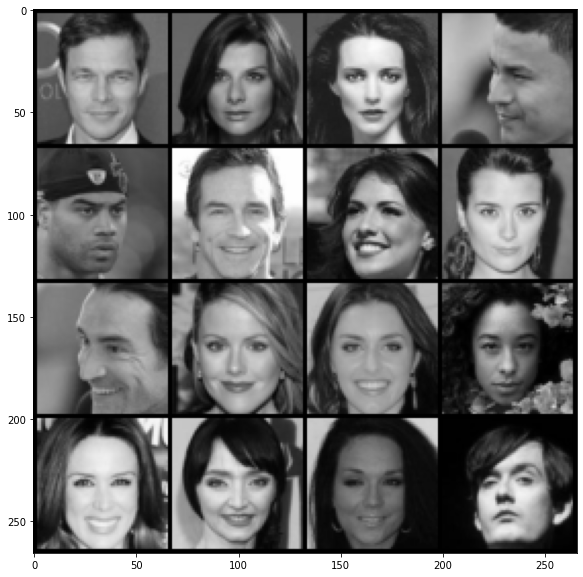

In [ ]:
samples = torch.stack([train_dataset[i][0]*0.5+0.5 for i in range(32, 48)], dim=0)
classes = [train_dataset[i][1] for i in range(32, 48)]

print(classes)
# print(train_dataset[0][0])

plt.figure(figsize=(10, 10))
plt.imshow(make_grid(samples, nrow=4).permute(1, 2, 0))
plt.show()

In [ ]:
def sample_noise_batch(batch_size):
    noise = torch.randn(batch_size, CODE_SIZE)
    return noise.cuda() if use_cuda else noise.cpu()
    
class Reshape(nn.Module):
    def __init__(self, shape):
        nn.Module.__init__(self)
        self.shape = shape
    
    def forward(self,input):
        return input.view(self.shape)

In [ ]:
CODE_SIZE = 100 # Size of z noise vector; feel free to change it

generator = nn.Sequential()

## YOUR CODE - create architecture for discriminator
## Note: please start simple. You can start with the layers below, but you are more than welcome to change it

generator.add_module('linear1', nn.Linear(CODE_SIZE, 10*8*8))
generator.add_module('act1', nn.LeakyReLU(0.2))
generator.add_module('reshape1', Reshape([-1, 10, 8, 8]))

generator.add_module('conv2', nn.ConvTranspose2d(10, 64, kernel_size=4, stride=2, padding=1))
generator.add_module('act2', nn.LeakyReLU(0.2))

generator.add_module('conv3', nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1))
generator.add_module('act3', nn.LeakyReLU(0.2))

generator.add_module('conv4', nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1))
generator.add_module('act4', nn.LeakyReLU(0.2))

# generator.add_module('conv5', nn.ConvTranspose2d(16, 8, kernel_size=4, stride=2, padding=3))
# generator.add_module('act5', nn.ELU())

generator.add_module('conv6', nn.Conv2d(16, 1, kernel_size=(1,1)))
generator.add_module('act4', nn.Tanh())
# generator.add_module('reshape2', Reshape([-1, 64, 64]))



##TODO: define next layers

if use_cuda: generator.cuda()

generated_data = generator(sample_noise_batch(5))
print(generated_data.shape)

torch.Size([5, 1, 64, 64])


In [ ]:
generated_data = generator(sample_noise_batch(5))
print(generated_data.shape)
assert tuple(generated_data.shape)[1:] == IMG_SHAPE, "generator must output an image of shape %s, but instead it produces %s"%(IMG_SHAPE, tuple(generated_data.shape)[1:])

torch.Size([5, 1, 64, 64])


In [ ]:
def sample_data_batch(batch_size):
    idxs = np.random.choice(np.arange(len(train_dataset)), size=batch_size)
    batch = torch.stack([train_dataset[idx][0] for idx in idxs], dim=0)
    return batch.cuda() if use_cuda else batch.cpu()

# a special module that converts [batch, channel, w, h] to [batch, units]
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.shape[0], -1)

In [ ]:
discriminator = nn.Sequential()

## YOUR CODE - create convolutional architecture for discriminator
## Note: please start simple. A few convolutions & poolings would do, inception/resnet is an overkill

discriminator.add_module('reshape1', Reshape([-1, 1, 64, 64]))

discriminator.add_module("conv1", nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1))
discriminator.add_module('act1', nn.ELU())

discriminator.add_module("conv2", nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1))
discriminator.add_module('act2', nn.ELU())

# discriminator.add_module("conv3", nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1))
# discriminator.add_module('act3', nn.ELU())

discriminator.add_module('flatten', Flatten())

discriminator.add_module("disc_logit", nn.Linear(64*16*16, 1))

if use_cuda: discriminator.cuda()

discriminated_data = discriminator(sample_data_batch(4))
print(discriminated_data.shape)

torch.Size([4, 1])


In [ ]:
def generator_loss(noise):
    """
    1. generate data given noise
    2. compute log P(real | gen noise)
    3. return generator loss (should be scalar)
    """
    generated_data = generator(noise)
    
    disc_on_generated_data = discriminator(generated_data)
    
    logp_gen_is_real = F.logsigmoid(disc_on_generated_data)
    
    loss = -torch.mean(logp_gen_is_real)
    
    return loss

In [ ]:
loss = generator_loss(sample_noise_batch(32))

print(loss)
print(loss.requires_grad)

assert len(loss.shape) == 0, "Loss must be scalar"

tensor(0.6730, device='cuda:0', grad_fn=<NegBackward0>)
True


In [ ]:
def discriminator_loss(real_data, generated_data):
    """
    1. compute discriminator's output on real & generated data
    2. compute log-probabilities of real data being real, generated data being fake
    3. return discriminator loss (scalar)
    """
    disc_on_real_data = discriminator(real_data)
    disc_on_fake_data = discriminator(generated_data)
    
    logp_real_is_real = F.logsigmoid(disc_on_real_data)
    logp_gen_is_fake = F.logsigmoid(-disc_on_fake_data)
    
    loss = -torch.mean(logp_real_is_real) - torch.mean(logp_gen_is_fake)
    return loss

In [ ]:
loss = discriminator_loss(sample_data_batch(32), 
                   generator(sample_noise_batch(32)))

print(loss)
print(loss.requires_grad)

assert len(loss.shape) == 0, "Loss must be scalar"  

tensor(1.3948, device='cuda:0', grad_fn=<SubBackward0>)
True


In [ ]:
def sample_images(nrow, ncol, sharp=False):
    images = generator(sample_noise_batch(batch_size=nrow*ncol))
    images = images.data.cpu().numpy().transpose([0, 2, 3, 1]).squeeze()*0.5+0.5
    if np.var(images)!=0:
        images = images.clip(0, 1)
    for i in range(nrow*ncol):
        plt.subplot(nrow,ncol,i+1)
        if sharp:
            plt.imshow(images[i], cmap="gray", interpolation="none")
        else:
            plt.imshow(images[i], cmap="gray")
    plt.show()

def sample_probas(batch_size):
    plt.title('Generated vs real data')
    D_real = torch.sigmoid(discriminator(sample_data_batch(batch_size)))
    generated_data_batch = generator(sample_noise_batch(batch_size))
    D_fake = torch.sigmoid(discriminator(generated_data_batch))
    
    plt.hist(D_real.data.cpu().numpy(),
             label='D(x)', alpha=0.5, range=[0,1])
    plt.hist(D_fake.data.cpu().numpy(),
             label='D(G(z))', alpha=0.5, range=[0,1])
    plt.legend(loc='best')
    plt.show()

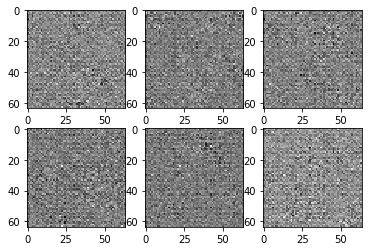

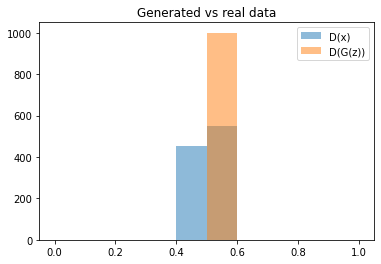

In [ ]:
sample_images(2,3,True)
sample_probas(1000)

  0%|          | 0/1627 [00:00<?, ?it/s]

Epoch 1 of 25 took 290.621s
  discriminator loss (in-iteration): 	0.060747
  generator loss (in-iteration): 	8.544793


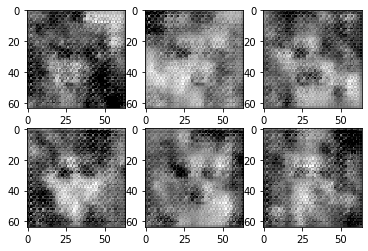

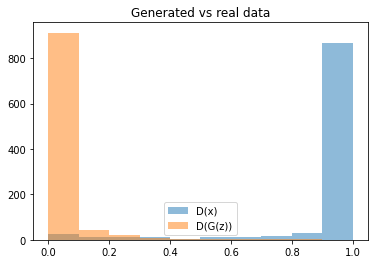

  0%|          | 0/1627 [00:00<?, ?it/s]

Epoch 2 of 25 took 288.192s
  discriminator loss (in-iteration): 	0.295670
  generator loss (in-iteration): 	4.545157


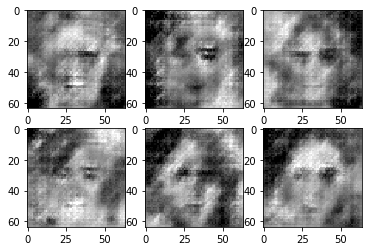

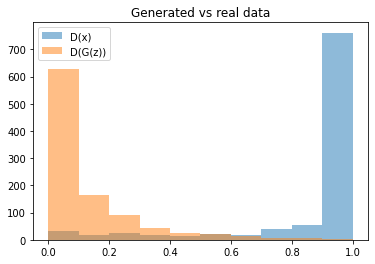

  0%|          | 0/1627 [00:00<?, ?it/s]

Epoch 3 of 25 took 288.596s
  discriminator loss (in-iteration): 	0.494555
  generator loss (in-iteration): 	3.688661


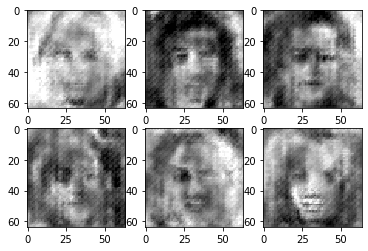

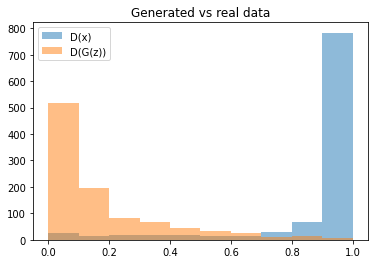

  0%|          | 0/1627 [00:00<?, ?it/s]

Epoch 4 of 25 took 290.945s
  discriminator loss (in-iteration): 	0.659701
  generator loss (in-iteration): 	3.414637


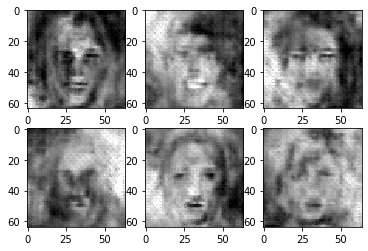

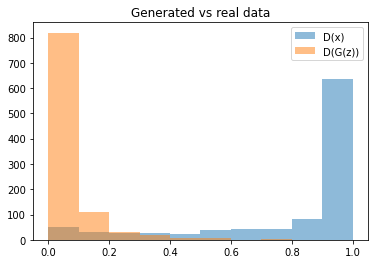

  0%|          | 0/1627 [00:00<?, ?it/s]

Epoch 5 of 25 took 291.557s
  discriminator loss (in-iteration): 	0.669000
  generator loss (in-iteration): 	3.074731


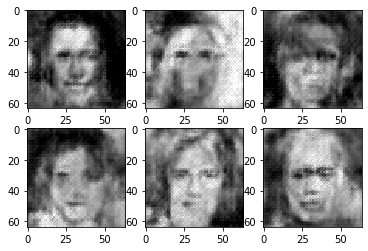

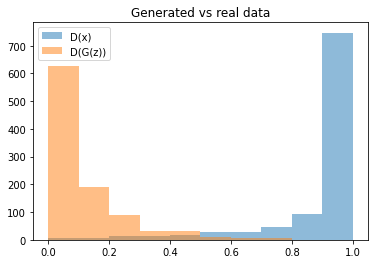

  0%|          | 0/1627 [00:00<?, ?it/s]

Epoch 6 of 25 took 292.443s
  discriminator loss (in-iteration): 	0.646021
  generator loss (in-iteration): 	3.055068


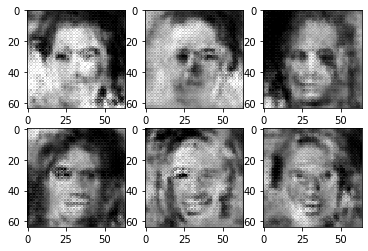

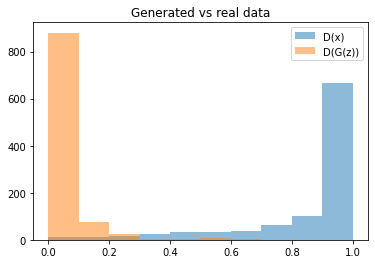

  0%|          | 0/1627 [00:00<?, ?it/s]

Epoch 7 of 25 took 293.781s
  discriminator loss (in-iteration): 	0.682553
  generator loss (in-iteration): 	3.091916


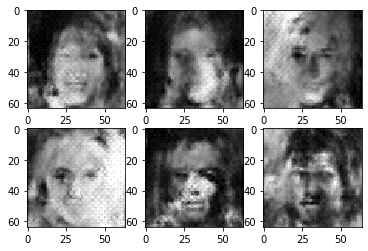

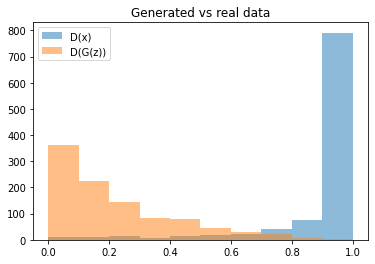

  0%|          | 0/1627 [00:00<?, ?it/s]

Epoch 8 of 25 took 294.660s
  discriminator loss (in-iteration): 	0.768543
  generator loss (in-iteration): 	2.857441


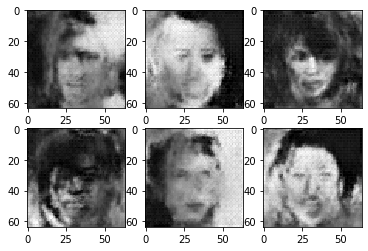

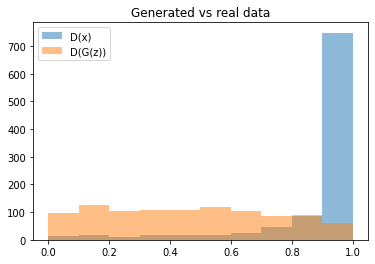

  0%|          | 0/1627 [00:00<?, ?it/s]

Epoch 9 of 25 took 295.985s
  discriminator loss (in-iteration): 	0.770642
  generator loss (in-iteration): 	2.598817


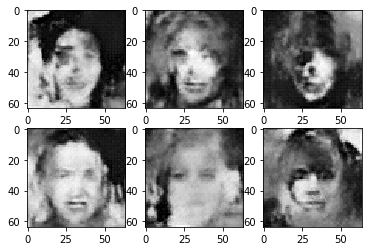

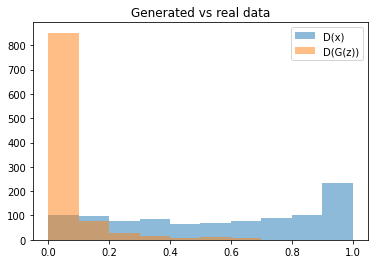

  0%|          | 0/1627 [00:00<?, ?it/s]

Epoch 10 of 25 took 295.902s
  discriminator loss (in-iteration): 	0.798007
  generator loss (in-iteration): 	2.404973


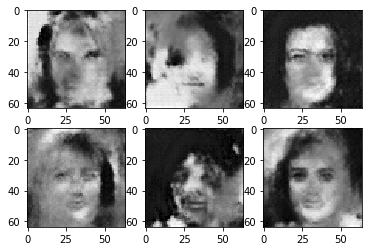

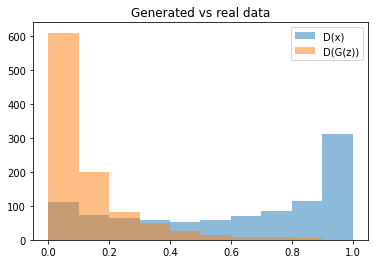

  0%|          | 0/1627 [00:00<?, ?it/s]

Epoch 11 of 25 took 298.144s
  discriminator loss (in-iteration): 	0.801858
  generator loss (in-iteration): 	2.360113


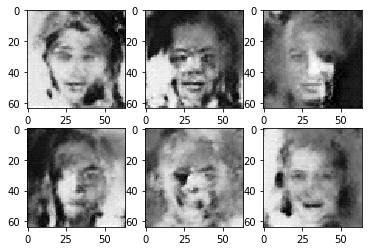

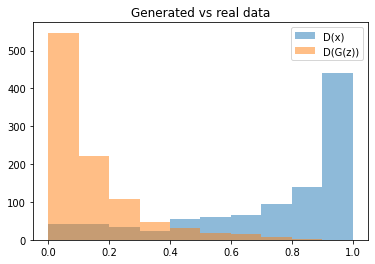

  0%|          | 0/1627 [00:00<?, ?it/s]

Epoch 12 of 25 took 298.904s
  discriminator loss (in-iteration): 	0.853935
  generator loss (in-iteration): 	2.271019


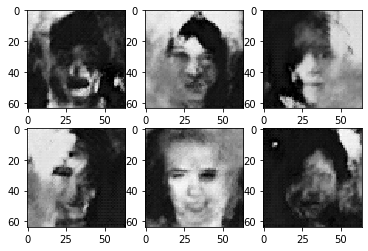

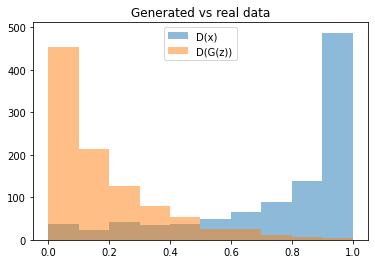

  0%|          | 0/1627 [00:00<?, ?it/s]

Epoch 13 of 25 took 302.705s
  discriminator loss (in-iteration): 	0.899505
  generator loss (in-iteration): 	2.243607


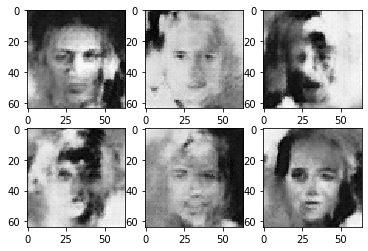

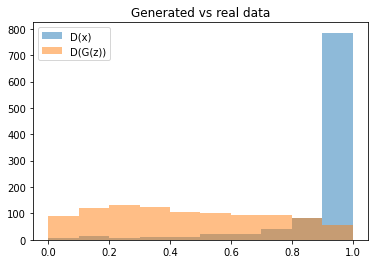

  0%|          | 0/1627 [00:00<?, ?it/s]

Epoch 14 of 25 took 302.752s
  discriminator loss (in-iteration): 	0.911862
  generator loss (in-iteration): 	2.294140


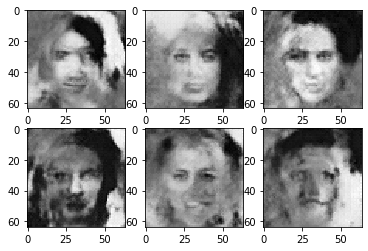

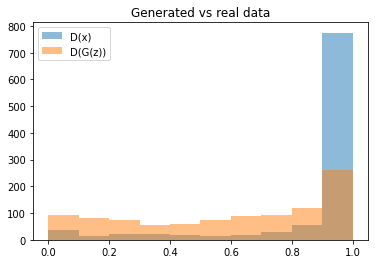

  0%|          | 0/1627 [00:00<?, ?it/s]

Epoch 15 of 25 took 304.532s
  discriminator loss (in-iteration): 	0.924122
  generator loss (in-iteration): 	2.344275


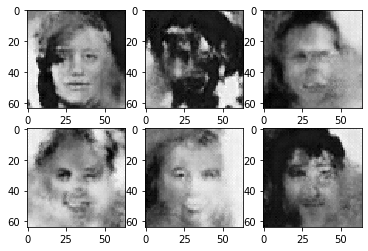

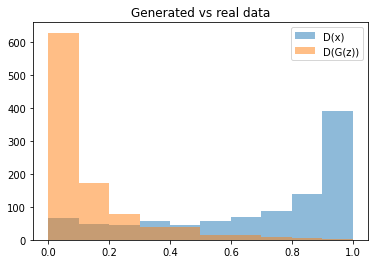

  0%|          | 0/1627 [00:00<?, ?it/s]

Epoch 16 of 25 took 305.258s
  discriminator loss (in-iteration): 	0.954056
  generator loss (in-iteration): 	2.326344


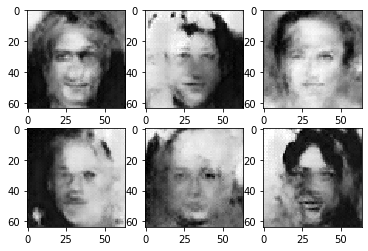

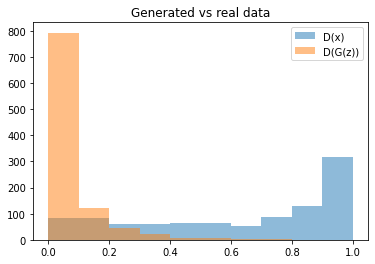

  0%|          | 0/1627 [00:00<?, ?it/s]

Epoch 17 of 25 took 306.433s
  discriminator loss (in-iteration): 	0.963612
  generator loss (in-iteration): 	2.392547


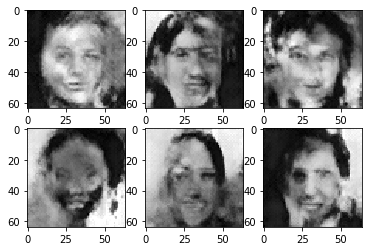

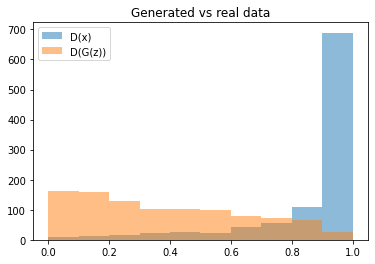

  0%|          | 0/1627 [00:00<?, ?it/s]

Epoch 18 of 25 took 307.722s
  discriminator loss (in-iteration): 	0.993304
  generator loss (in-iteration): 	2.394494


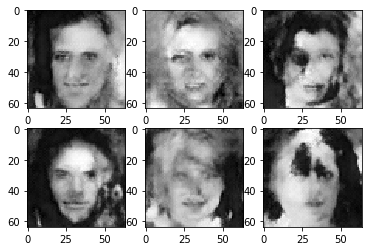

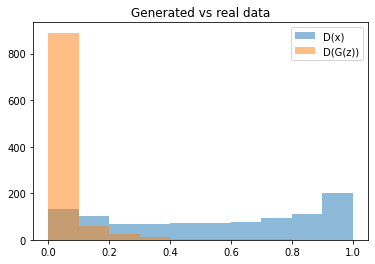

  0%|          | 0/1627 [00:00<?, ?it/s]

Epoch 19 of 25 took 308.155s
  discriminator loss (in-iteration): 	0.987160
  generator loss (in-iteration): 	2.446402


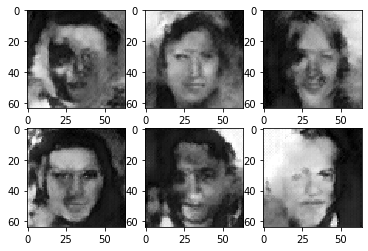

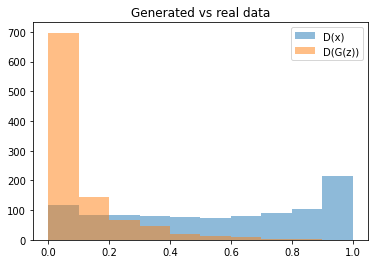

  0%|          | 0/1627 [00:00<?, ?it/s]

Epoch 20 of 25 took 306.192s
  discriminator loss (in-iteration): 	1.015234
  generator loss (in-iteration): 	2.405169


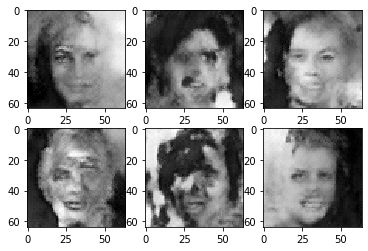

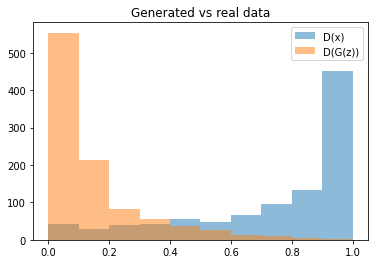

  0%|          | 0/1627 [00:00<?, ?it/s]

In [ ]:
from IPython import display
from tqdm.auto import tqdm
import time

# optimizers
# disc_opt = torch.optim.SGD(discriminator.parameters(), lr=5e-3)
# gen_opt = torch.optim.Adam(generator.parameters(), lr=1e-4)

batch_size = 100
loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

num_epochs = 25

for epoch in range(num_epochs):
    start_time = time.time()

    iteration = 0
    train_lossD = []
    train_lossG = []
    for batch, _ in tqdm(loader):

        # Train discriminator
        real_data = batch.cuda() if use_cuda else batch.cpu()
        fake_data = generator(sample_noise_batch(batch_size))
        loss = discriminator_loss(real_data, fake_data)
        disc_opt.zero_grad()
        loss.backward()
        disc_opt.step()

        train_lossD.append(loss.cpu().data.numpy())

        # Train generator
        if True: #or iteration % 5 == 0:
          noise = sample_noise_batch(batch_size)
          loss = generator_loss(noise)
          gen_opt.zero_grad()
          loss.backward()
          gen_opt.step()
          train_lossG.append(loss.cpu().data.numpy())
        
        iteration+=1

    
    print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
    print("  discriminator loss (in-iteration): \t{:.6f}".format(np.mean(train_lossD)))
    print("  generator loss (in-iteration): \t{:.6f}".format(np.mean(train_lossG)))

    # display.clear_output(wait=True)
    sample_images(2,3,True)
    sample_probas(1000)